# 1. Imports

In [1]:
import sys
from pathlib import Path

# Add project root (parent of "electricity") to sys.path

sys.path.append("..")   # go up one level to project root


from electricity.load import Loading
from electricity.preprocessing import Preprocessor



In [2]:
loader = Loading(filepath="complete_dataset.csv", return_X_y=True)

In [3]:
# 3. Load the dataframe
X,y = loader.load_data()

In [4]:
# --- Notebook Cell 3: Simple model with unified preprocessing (LinearRegression + TS CV) ---

# Build preprocessing + model pipeline.
# Preprocessor will add date/cyclical features, impute/scale/one-hot, and prune highly correlated features.
pre = Preprocessor(
    filepath="",                 # not used when we pass data directly
    add_date_features=True,      # safe: loader didn't create date features
    corr_threshold=0.95
)


In [5]:
import pandas as pd

In [6]:
pre.set_data(pd.concat([X, y.rename(pre.target_col)], axis=1))

Preprocessor(filepath='', date_col='date', target_col='RRP', leaky_cols=('RRP_positive', 'RRP_negative', 'demand_pos_RRP', 'demand_neg_RRP', 'frac_at_neg_RRP'), bool_maps={'holiday': {'Y': 1, 'N': 0}, 'school_day': {'Y': 1, 'N': 0}}, corr_threshold=0.95, add_date_features=True, random_state=42, df=                demand  min_temperature  max_temperature  solar_exposure  \
date                                                                       
2015-01-01   99635.030             13.3             26.9            23.6   
2015-01-02  129606.010             15.4             38.8            26.8   
2015-01-03  142300.540             20.0             38.2            26.5   
2015-01-04  104330.715             16.3             21.4            25.2   
2015-01-05  118132.200             15.0             22.0            30.7   
...                ...              ...              ...             ...   
2020-10-02   99585.835             12.8             26.0            22.0   
2020-10-03   9227

In [7]:
pipeline = pre.build_pipeline()

In [8]:
pipeline

,steps,"[('date_features', ...), ('pre', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,date_col,'date'
,transformers,"[('pipeline-1', ...), ('pipeline-2', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False


In [9]:
from electricity.models import _tscv_scores
from sklearn.ensemble import RandomForestRegressor


2025-08-26 12:12:47.085034: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-26 12:12:47.085768: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-26 12:12:47.155215: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-26 12:12:49.399525: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off,

In [10]:
#_tscv_scores(pipeline, X, y, model=RandomForestRegressor())

In [11]:
X.shape

(2106, 7)

In [12]:
y.shape

(2106,)

In [13]:
pipeline.fit(X)
X = pipeline.transform(X)

🔎 CorrelationSelector dropped 6 features: [9, 11, 14, 15, 16, 17]


In [14]:
from sklearn.model_selection import TimeSeriesSplit

In [15]:
X.shape

(2106, 12)

In [16]:
train_size = 0.6
index = round(train_size*X.shape[0])

X_train = X.iloc[:index]
X_test = X.iloc[index:]
y_train = y.iloc[:index]
y_test = y.iloc[index:]


In [17]:
# tscv = TimeSeriesSplit(n_splits=5)
# splits = list(tscv.split(X, y))
# X_train, X_test = X.iloc[splits[0][0]], X.iloc[splits[0][1]]
# y_train, y_test = y.iloc[splits[0][0]], y.iloc[splits[0][1]]
X_train.shape, X_test.shape, y_train.shape, y_test.shape




((1264, 12), (842, 12), (1264,), (842,))

In [18]:
X_train.shape[-1]

12

In [19]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras import layers


In [20]:
from tensorflow.keras.callbacks import EarlyStopping


In [21]:
es = EarlyStopping(patience=10, restore_best_weights=True)
model = Sequential()
model.add(layers.Dense(21, input_shape=(X_train.shape[-1],), activation="relu"))
model.add(layers.Dense(14, activation="relu"))
model.add(layers.Dense(7, activation="relu"))
model.add(layers.Dense(1, activation="linear"))

model.compile(optimizer="adam", loss="mse", metrics=["mae"])
model.fit(X_train, y_train, epochs=1000, callbacks=[es], validation_split=0.2, batch_size=32, verbose=1)


/home/kieren/.pyenv/versions/electricity/lib/python3.10/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-08-26 12:12:50.562416: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Epoch 1/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4755.6948 - mae: 57.0831 - val_loss: 16553.6855 - val_mae: 93.3017
Epoch 2/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4545.1118 - mae: 55.1764 - val_loss: 16140.4941 - val_mae: 90.6996
Epoch 3/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4144.8511 - mae: 51.3269 - val_loss: 15452.4023 - val_mae: 86.3804
Epoch 4/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3568.0583 - mae: 45.7189 - val_loss: 14634.0186 - val_mae: 82.0398
Epoch 5/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3010.6292 - mae: 39.4079 - val_loss: 13701.6963 - val_mae: 77.0155
Epoch 6/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2498.0652 - mae: 33.7234 - val_loss: 12523.3066 - val_mae: 70.4417
Epoch 7/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2058.4329 - mae: 30.7817 - val_loss: 11406.8877 - val_mae: 63.5299
Epoch 8/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1765.1526 - mae: 29.6338 - val_loss: 10647.9014 - 

In [22]:
model.evaluate(X_test, y_test)

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 39128.0469 - mae: 67.7139


[39128.046875, 67.71388244628906]

In [23]:
import matplotlib.pyplot as plt

In [24]:
y_test

date
2018-06-18    112.501498
2018-06-19    110.056190
2018-06-20     91.289342
2018-06-21    141.556978
2018-06-22    131.562133
                 ...    
2020-10-02     -6.076028
2020-10-03     -1.983471
2020-10-04     25.008614
2020-10-05     36.764701
2020-10-06     75.771059
Name: RRP, Length: 842, dtype: float64

In [25]:
X_test

,0,1,2,3,4,5,6,7,8,10,12,13
1264,0.924799,-0.295082,-0.847761,-0.544,9.00,0.0,0.0,0.333333,0.000000,-0.75,0.000000,-0.732051
1265,1.184241,-1.360656,-0.549254,-0.296,0.50,0.0,0.0,0.333333,0.000000,-0.50,0.000000,-0.732051
1266,1.060941,-1.147541,-0.453731,-0.376,0.25,0.0,0.0,0.333333,0.000000,-0.25,0.000000,-0.732051
1267,1.170169,-1.196721,-0.477612,-0.288,0.00,0.0,0.0,0.333333,0.000000,0.00,0.000000,-0.732051
1268,1.011632,-1.147541,-0.489552,-0.336,0.00,0.0,0.0,0.333333,0.000000,0.25,0.000000,-0.732051
...,...,...,...,...,...,...,...,...,...,...,...,...
2101,-0.976931,0.245902,0.823881,0.744,0.00,-1.0,0.0,1.000000,0.666667,0.25,-0.527889,0.366025
2102,-1.333940,1.000000,1.229851,0.568,0.00,-1.0,0.0,1.000000,0.666667,0.50,-0.527889,0.366025
2103,-1.245794,0.360656,1.241791,-0.344,0.00,-1.0,0.0,1.000000,0.666667,0.75,-0.527889,0.366025
2104,-0.291900,-0.360656,-0.764179,-0.432,16.00,-1.0,0.0,1.000000,0.666667,-0.75,-0.527889,0.366025


In [26]:
y_pred = model.predict(X_test)

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


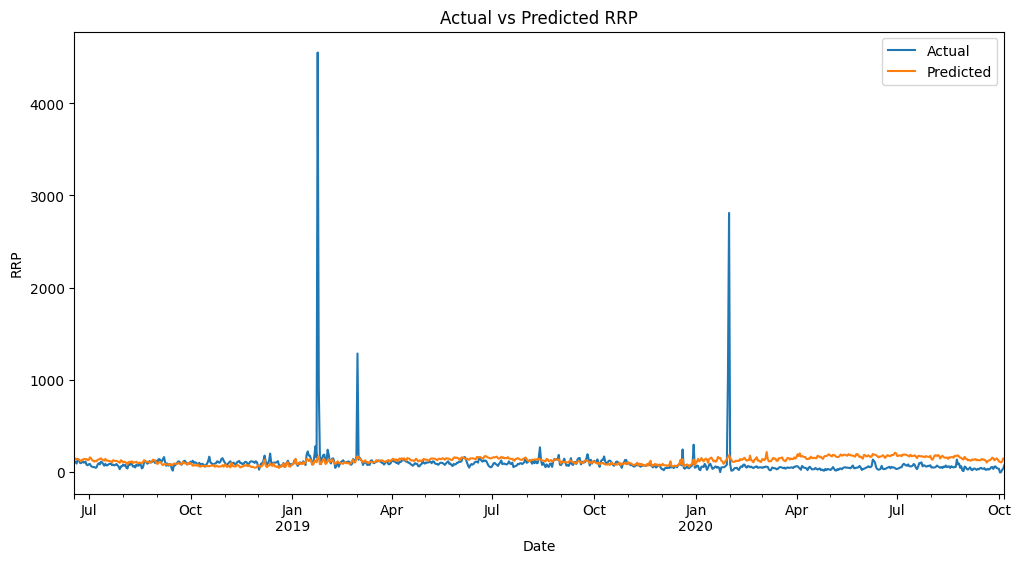

In [27]:
import pandas as pd

# Assume y_test is a pandas Series with date index, X_test is a DataFrame with date index
# If y_test is not a Series with index, adjust accordingly

# Convert y_pred to Series with same index as y_test
y_pred_series = pd.Series(y_pred.flatten(), index=y_test.index, name="Predicted")
y_test_series = pd.Series(y_test, index=y_test.index, name="Actual")

# Combine into a DataFrame
df_pred = pd.DataFrame({"Actual": y_test_series, "Predicted": y_pred_series})

# Plot both against date
df_pred.plot(figsize=(12, 6))
plt.xlabel("Date")
plt.ylabel("RRP")
plt.title("Actual vs Predicted RRP")
plt.show()
